In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import random
import os
from PIL import Image


In [2]:

# Load the CIFAR-10 dataset
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Exploring the dataset
print("Training set shape:", x_train.shape)
print("Test set shape:", x_test.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step
Training set shape: (50000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)


In [3]:
print('Train Images Shape:      ', x_train.shape)
print('Train Labels Shape:      ', y_train.shape)

print('\nTest Images Shape:       ', x_test.shape)
print('Test Labels Shape:       ', y_test.shape)

Train Images Shape:       (50000, 32, 32, 3)
Train Labels Shape:       (50000, 1)

Test Images Shape:        (10000, 32, 32, 3)
Test Labels Shape:        (10000, 1)


In [4]:
print(f"Original x_train min: {x_train.min()}, max: {x_train.max()}")
print(f"Original x_test min: {x_test.min()}, max: {x_test.max()}")


Original x_train min: 0, max: 255
Original x_test min: 0, max: 255


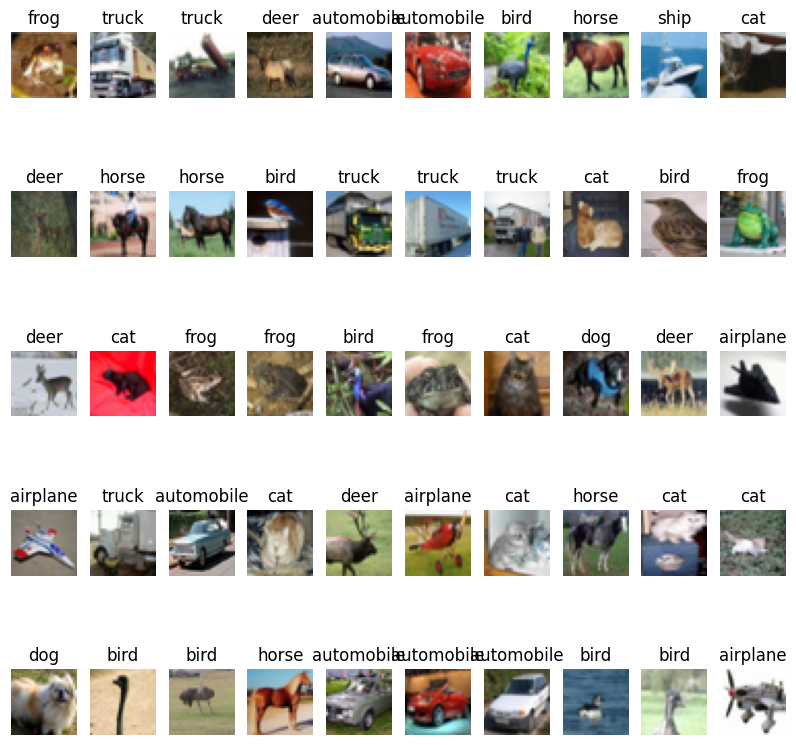

In [5]:
import matplotlib.pyplot as plt

# CIFAR-10 classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 10))  # Adjust figure size for better visualization
for i in range(50):  # Loop over the first 20 images
    ax = plt.subplot(5, 10, i + 1)  # 5 rows and 4 columns
    plt.imshow(x_train[i])  # Display the image
    plt.axis("off")  # Hide the axis
    plt.title(class_names[y_train[i][0]], fontsize=12)  # Set the label as the title

# Display the figure
plt.show()


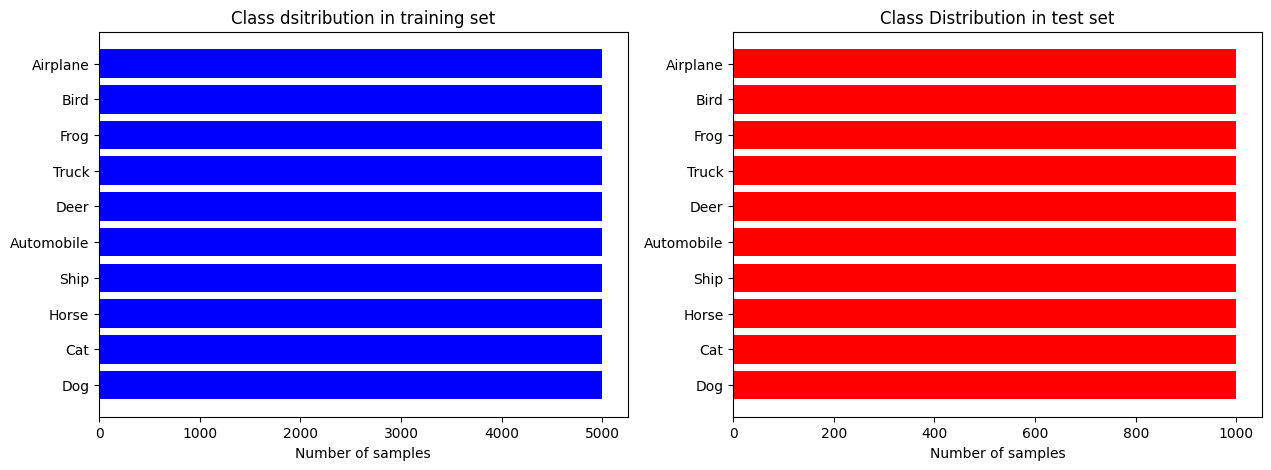

In [6]:
classes_name = ['Dog','Cat','Horse','Ship','Automobile','Deer','Truck','Frog','Bird','Airplane']

train_class, train_counts = np.unique(y_train,return_counts=True)
test_class,test_counts = np.unique(y_test,return_counts=True)
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.barh(classes_name,train_counts,color='blue')
plt.xlabel('Number of samples')
plt.title('Class dsitribution in training set')

plt.subplot(1,2,2)
plt.barh(classes_name,test_counts,color='red')
plt.xlabel('Number of samples')
plt.title('Class Distribution in test set')

plt.show()

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,  # Shift horizontally by 20%
    height_shift_range=0.2  # Shift vertically by 20%
)

test_datagen=ImageDataGenerator(rescale=1./255)

# Use data generators for CIFAR-10
train_generator = train_datagen.flow(x_train, y_train, batch_size=64)
validation_generator = test_datagen.flow(x_test, y_test, batch_size=64)


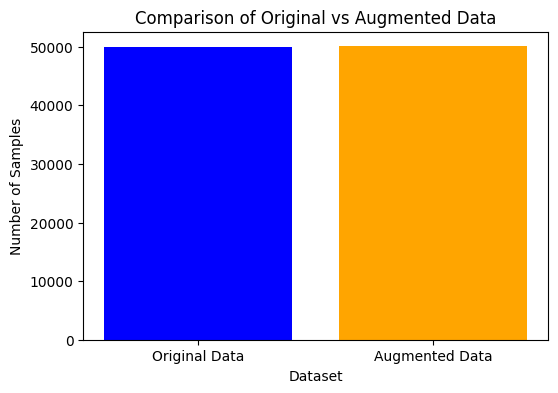

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Count how many augmented samples are generated
def count_augmented_samples(generator, original_data_size):
    batches = len(generator)  # Total number of batches
    augmented_data_size = batches * generator.batch_size
    return augmented_data_size

# Count augmented samples
original_train_size = len(x_train)
augmented_train_size = count_augmented_samples(train_generator, original_train_size)

# Plot the bar chart
labels = ['Original Data', 'Augmented Data']
counts = [original_train_size, augmented_train_size]

plt.figure(figsize=(6, 4))
plt.bar(labels, counts, color=['blue', 'orange'])
plt.xlabel('Dataset')
plt.ylabel('Number of Samples')
plt.title('Comparison of Original vs Augmented Data')
plt.show()


In [9]:
!pip install keras-tuner --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 12.5 MB/s eta 0:00:00


In [10]:
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout

# Define the model building function
def build_model(hp):
    model = Sequential()

    # Add convolutional layers
    for i in range(hp.Int('num_layers', min_value=1, max_value=5, step=1)):
        if i == 0:  # First layer with input_shape
            model.add(Conv2D(
                filters=hp.Int('filters', min_value=32, max_value=128, step=32),
                kernel_size=hp.Choice('kernel_size', values=[3, 5]),
                activation='relu',
                input_shape=(32, 32, 3),
                padding='same'
            ))
        else:  # Subsequent layers
            model.add(Conv2D(
                filters=hp.Int('filters', min_value=32, max_value=128, step=32),
                kernel_size=hp.Choice('kernel_size', values=[3, 5]),
                activation='relu',
                padding='same'
            ))
        # Add Batch Normalization and Pooling
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    # Flatten the layers before Dense layers
    model.add(Flatten())

    # Dense Layer
    model.add(Dense(
        units=hp.Int('units', min_value=32, max_value=320, step=32),
        activation='relu'
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))

    # Output layer for multiclass classification
    model.add(Dense(10, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=hp.Choice('optimizer', values=['rmsprop', 'adam', 'sgd', 'adagrad']),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [11]:
tuner = kt.RandomSearch(
    build_model,
    max_trials=5,
    objective='val_accuracy',
    directory='myproject',
    project_name='CIFAR8'
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
tuner.search(train_generator,validation_data=validation_generator,epochs=5)

Trial 5 Complete [00h 03m 26s]
val_accuracy: 0.5097000002861023

Best val_accuracy So Far: 0.5752000212669373
Total elapsed time: 00h 19m 54s


In [13]:
tuner.get_best_hyperparameters()[0].values

{'num_layers': 5,
 'filters': 128,
 'kernel_size': 3,
 'units': 32,
 'dropout': 0.1,
 'optimizer': 'sgd'}

In [14]:
model = tuner.get_best_models(num_models=1)[0]

In [15]:
history= model.fit(train_generator,validation_data=validation_generator,epochs=15,initial_epoch=5)

Epoch 6/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 46s 53ms/step - accuracy: 0.5809 - loss: 1.1816 - val_accuracy: 0.6316 - val_loss: 1.0391
Epoch 7/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - accuracy: 0.6065 - loss: 1.1234 - val_accuracy: 0.5871 - val_loss: 1.1486
Epoch 8/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 80s 51ms/step - accuracy: 0.6158 - loss: 1.0845 - val_accuracy: 0.6061 - val_loss: 1.1758
Epoch 9/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.6263 - loss: 1.0518 - val_accuracy: 0.6814 - val_loss: 0.9019
Epoch 10/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.6481 - loss: 0.9963 - val_accuracy: 0.6749 - val_loss: 0.9474
Epoch 11/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 53ms/step - accuracy: 0.6547 - loss: 0.9888 - val_accuracy: 0.5671 - val_loss: 1.3080
Epoch 12/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 51ms/step - accuracy: 0.6650 - loss: 0.9620 - val_accuracy: 0.6042 - val_loss: 1.1621
Epoch 13/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.6745 - loss: 0.934

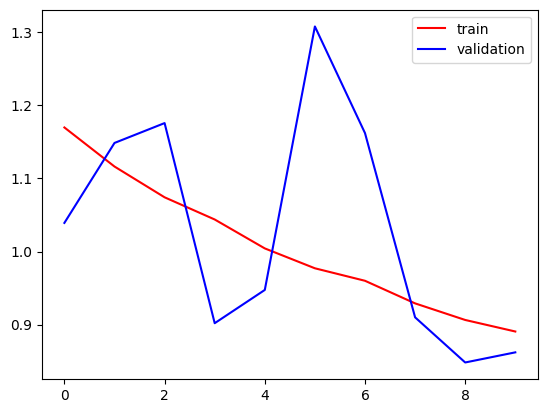

In [16]:
plt.plot(history.history['loss'], color='red',label='train')
plt.plot(history.history['val_loss'],color='blue', label='validation')
plt.legend()
plt.show()

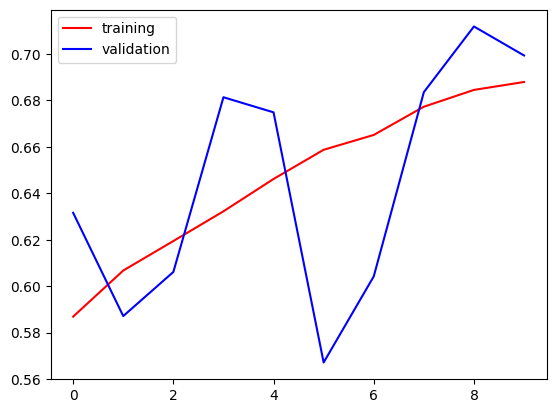

In [17]:
plt.plot(history.history['accuracy'],color='red',label='training')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()